### Aplicación de Modelos para la predicción de la demanda 

Primero de todo se ha obserbado cual es la distribucion de los datos de las ventas y compras diarias. 

1. Lectura y preparación de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
ventas=pd.read_csv(r'C:\Codeproject\Recursos\Datos Originales\SalesFINAL12312016.csv', parse_dates=['SalesDate'])
compras=pd.read_csv(r'C:\Codeproject\Recursos\Datos Originales\PurchasesFINAL12312016.csv', parse_dates=['ReceivingDate'])

In [2]:
fecha_inicio = '01/01/2016'
fecha_fin = '29/02/2016'
compras = compras[(compras['ReceivingDate'] >= fecha_inicio) & (compras['ReceivingDate'] <= fecha_fin)]

2. Análisis Exploratorio de Datos (EDA)

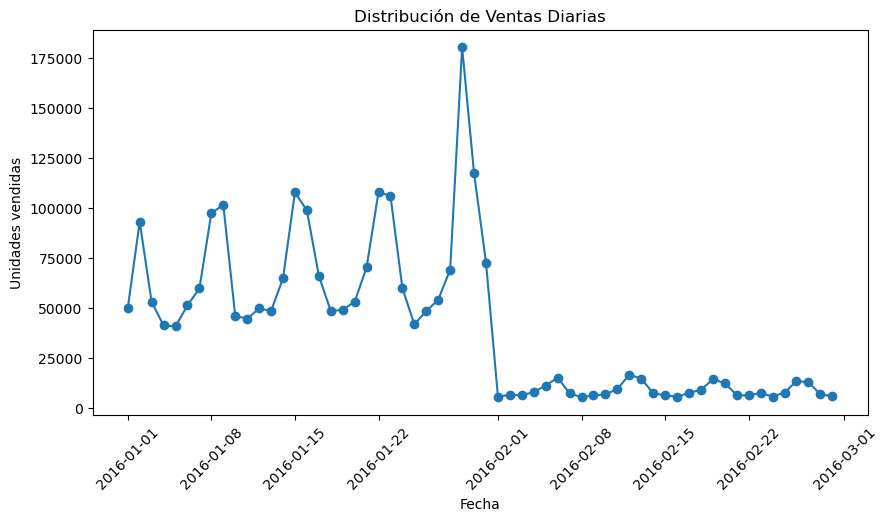

In [3]:
# Resamplear las ventas a diario
ventas.set_index('SalesDate', inplace=True)
ventas_diarias = ventas['SalesQuantity'].resample('D').sum()

# Mostrar la distribución de las ventas diarias
plt.figure(figsize=(10, 5))
plt.plot(ventas_diarias, marker='o', linestyle='-')
plt.title('Distribución de Ventas Diarias')
plt.xlabel('Fecha')
plt.ylabel('Unidades vendidas')
# Rotar las etiquetas del eje x
plt.xticks(rotation=45)
plt.show()

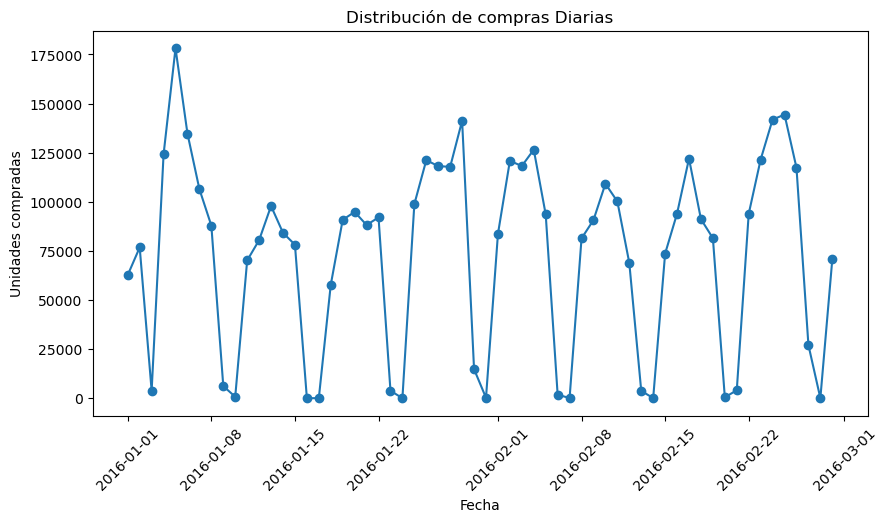

In [4]:
# Resamplear las compras a diario
compras.set_index('ReceivingDate', inplace=True)
compras_diarias = compras['Quantity'].resample('D').sum()

# Crear un DataFrame 
compras = compras_diarias.reset_index()
compras.columns = ['Fecha', 'Unidades compradas']

# Mostrar la distribución de las ventas diarias
plt.figure(figsize=(10, 5))
plt.plot(compras_diarias, marker='o', linestyle='-')
plt.title('Distribución de compras Diarias')
plt.xlabel('Fecha')
plt.ylabel('Unidades compradas')
# Rotar las etiquetas del eje x
plt.xticks(rotation=45)
plt.show()

Se ha observado que en las ventas hay un salto llamativo entre el último día de enero y el primero de febrero. Por ello, se ha hecho un ajuste comparando el valor de un pico de enero con un pico de febrero, y multiplicando todos los datos de febrero por esa proporción.

C:\Users\isaa1\AppData\Local\Temp\ipykernel_19868\3900747218.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 62383.22724822  70577.03876341  69106.90899287  86672.79779522
 121674.85806722 164514.0071895   79581.58360793  58643.04415553
  69225.81654784  73365.96141633 103082.04038104 180426.
 159509.08010305  80057.21382781  69042.05032652  60405.03792463
  83073.14181295  97882.53729555 156071.57078665 134581.7326703
  69939.26187766  68285.36588581  81603.01204242  62080.55347193
  84067.64136361 145023.97795219 140646.01797376  74219.93385657
  63831.7374633 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ventas_diarias.loc[ventas_diarias.index.month == 2] *= proporcion


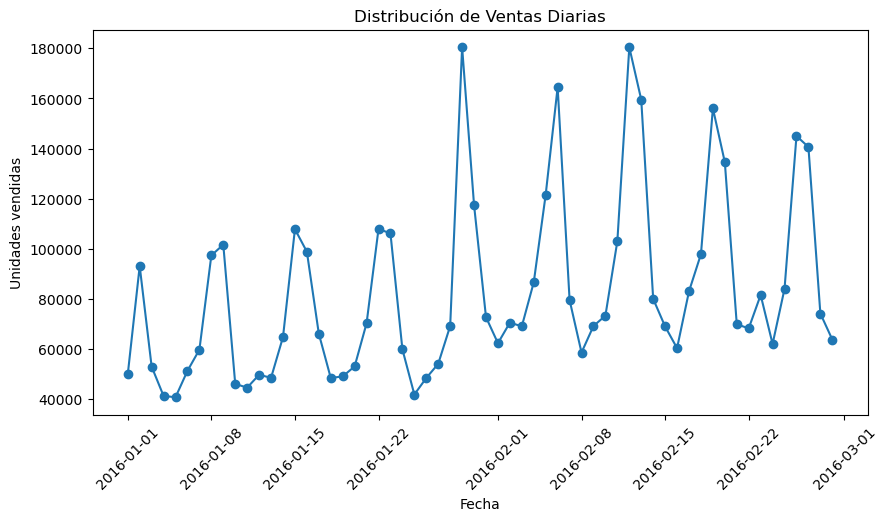

In [5]:
# Filtrar los datos por meses resampleados
enero = ventas_diarias[ventas_diarias.index.month == 1]
febrero = ventas_diarias[ventas_diarias.index.month == 2]

# Encontrar los picos basados en la suma diaria
pico_enero = enero.max()
pico_febrero = febrero.max()

# Calcular la proporción
proporcion = pico_enero / pico_febrero

# Ajustar las ventas de febrero
ventas_diarias.loc[ventas_diarias.index.month == 2] *= proporcion

# Crear un DataFrame ajustado
ventas = ventas_diarias.reset_index()
ventas.columns = ['Fecha', 'Unidades vendidas']

# Mostrar la distribución de las ventas diarias ajustadas
plt.figure(figsize=(10, 5))
plt.plot(ventas['Fecha'], ventas['Unidades vendidas'], marker='o')
plt.title('Distribución de Ventas Diarias')
plt.xlabel('Fecha')
plt.ylabel('Unidades vendidas')

# Rotar las etiquetas del eje x
plt.xticks(rotation=45)

plt.show()

In [6]:
# Suponiendo que 'Fecha' es la columna de fechas en ventas y compras_diarias
ventas['Fecha'] = pd.to_datetime(ventas['Fecha'])
compras_diarias.index = pd.to_datetime(compras_diarias.index)

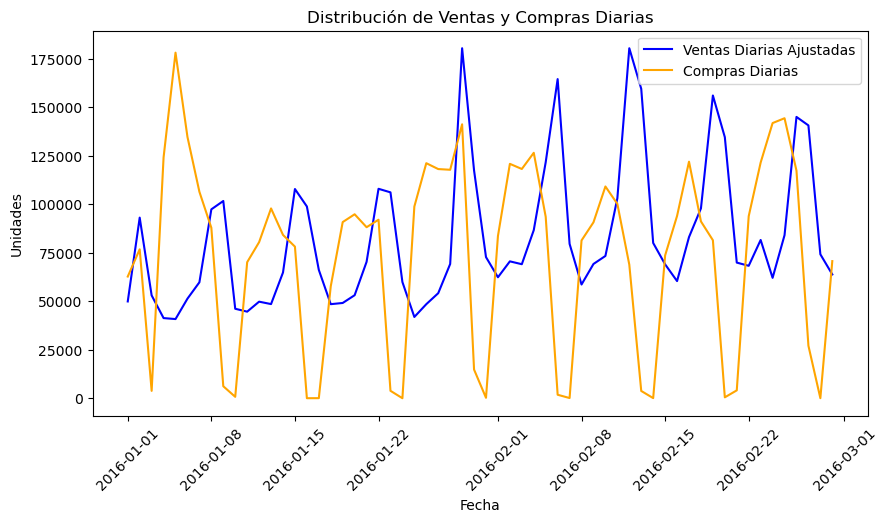

In [7]:
# Graficar ventas diarias ajustadas
plt.figure(figsize=(10, 5))
plt.plot(ventas['Fecha'], ventas['Unidades vendidas'], color='blue', label='Ventas Diarias Ajustadas')
plt.title('Distribución de Ventas y Compras Diarias')
plt.xlabel('Fecha')
plt.ylabel('Unidades')
plt.xticks(rotation=45)
plt.legend()

# Graficar compras diarias
plt.plot(compras['Fecha'], compras['Unidades compradas'], linestyle='-', color='orange', label='Compras Diarias')

# Mostrar leyenda y gráfico
plt.legend()
plt.show()

Juntar ambos datasets

In [8]:
# Combinar los DataFrames por la columna Fecha
df_compras_ventas = pd.merge(compras, ventas, on='Fecha', how='outer')

In [9]:
df_compras_ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Fecha               60 non-null     datetime64[ns]
 1   Unidades compradas  60 non-null     int64         
 2   Unidades vendidas   60 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.5 KB


3. Selección y Entrenamiento del Modelo

### Regresion lineal

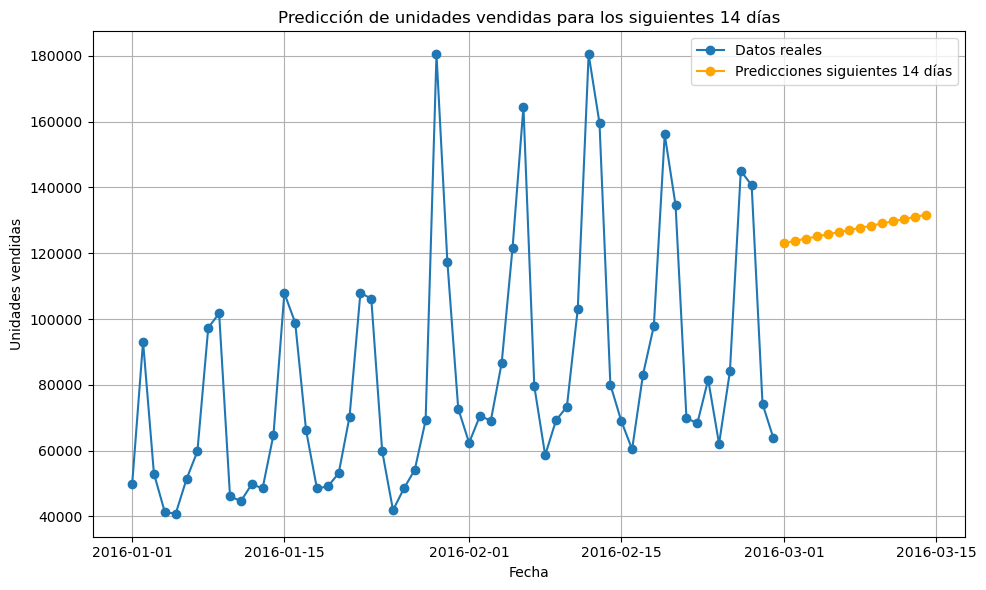

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Suponiendo que df_compras_ventas es tu DataFrame combinado con columnas 'Fecha', 'Unidades compradas', 'Unidades vendidas'

# Extraer características de la fecha (ejemplo: mes y día)
df_compras_ventas['Mes'] = df_compras_ventas['Fecha'].dt.month
df_compras_ventas['Dia'] = df_compras_ventas['Fecha'].dt.day

# Datos de entrenamiento
X_train = df_compras_ventas[['Mes', 'Dia', 'Unidades compradas']]
y_train = df_compras_ventas['Unidades vendidas']

# Entrenamiento del modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Crear datos para los siguientes 10 días
ultimo_dia = df_compras_ventas['Fecha'].max()
siguientes_14_dias = pd.date_range(start=ultimo_dia + pd.Timedelta(days=1), periods=14, freq='D')
X_next_14_steps = pd.DataFrame({
    'Fecha': siguientes_14_dias,
    'Mes': siguientes_14_dias.month,
    'Dia': siguientes_14_dias.day,
    'Unidades compradas': np.zeros(14)  # Puedes establecer un valor de compra predeterminado o utilizar la última observación conocida
})

# Predicción para los siguientes 10 días
y_pred_next_14_steps = model.predict(X_next_14_steps[['Mes', 'Dia', 'Unidades compradas']])

# Graficar las predicciones para los siguientes 10 días
plt.figure(figsize=(10, 6))
plt.plot(df_compras_ventas['Fecha'], y_train, label='Datos reales', marker='o')
plt.plot(siguientes_14_dias, y_pred_next_14_steps, label='Predicciones siguientes 14 días', marker='o', color='orange')
plt.title('Predicción de unidades vendidas para los siguientes 14 días')
plt.xlabel('Fecha')
plt.ylabel('Unidades vendidas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# Predicciones del modelo para los datos de entrenamiento
y_train_pred = model.predict(X_train)

# Métricas de evaluación del modelo
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)

print(f'MAE en datos de entrenamiento: {mae_train:.2f}')
print(f'RMSE en datos de entrenamiento: {rmse_train:.2f}')

# Calcular ventas promedio en los datos de entrenamiento
ventas_promedio_train = y_train.mean()

# Calcular porcentaje de error promedio en los datos de entrenamiento
porcentaje_error_promedio_train = (mae_train / ventas_promedio_train) * 100

print(f'El porcentaje de error promedio MAE en un día de ventas (datos de entrenamiento) es: {porcentaje_error_promedio_train:.2f}%')

# Suponiendo que ya tienes las predicciones en los datos de entrenamiento y has calculado el RMSE
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)

# Calcular ventas promedio en los datos de entrenamiento
ventas_promedio_train = y_train.mean()

# Calcular porcentaje de error promedio en los datos de entrenamiento
porcentaje_error_promedio_train_rmse = (rmse_train / ventas_promedio_train) * 100

print(f'El porcentaje de error promedio RMSE en un día de ventas (datos de entrenamiento) usando RMSE es: {porcentaje_error_promedio_train_rmse:.2f}%')

MAE en datos de entrenamiento: 25698.27
RMSE en datos de entrenamiento: 32271.98
El porcentaje de error promedio MAE en un día de ventas (datos de entrenamiento) es: 31.06%
El porcentaje de error promedio RMSE en un día de ventas (datos de entrenamiento) usando RMSE es: 39.00%


### Random forest

Nuevo MAE: 29343.223739376077
Nuevo RMSE: 34602.1217098694


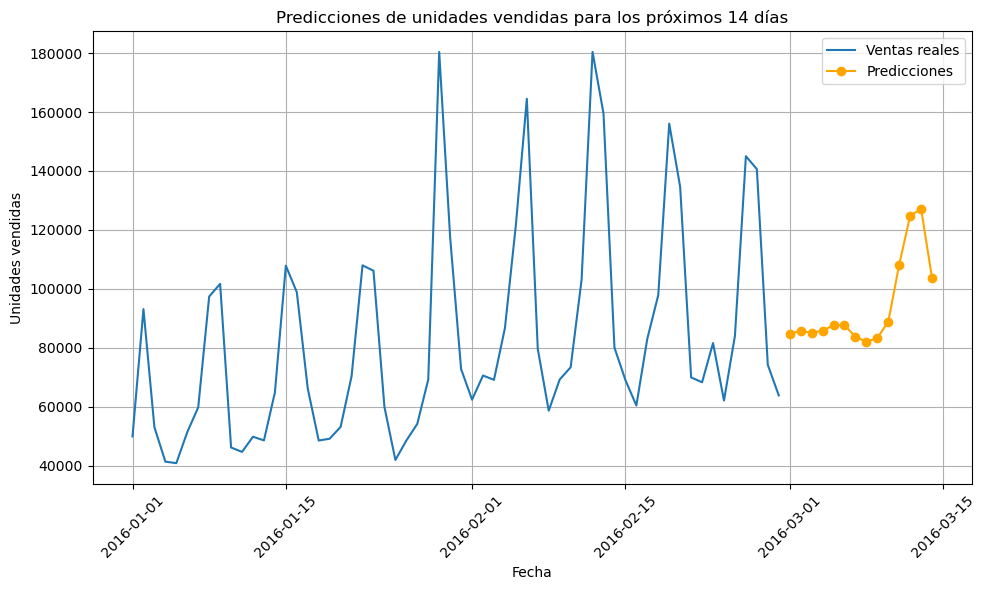

In [12]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

# Suponiendo que df_compras_ventas es tu DataFrame combinado con columnas 'Mes', 'Dia', 'Unidades compradas', 'Unidades vendidas'

# Datos de entrenamiento y prueba
X = df_compras_ventas[['Mes', 'Dia', 'Unidades compradas']]
y = df_compras_ventas['Unidades vendidas']

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear modelo Random Forest
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)

# Búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Nueva evaluación
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'Nuevo MAE: {mae}')
print(f'Nuevo RMSE: {rmse}')

# Predicción para los próximos 10 días
ultima_fecha = df_compras_ventas['Fecha'].max()  # Asumiendo que tienes una columna de fecha 'Fecha'
fechas_futuras = pd.date_range(start=ultima_fecha + pd.DateOffset(days=1), periods=14, freq='D')
datos_futuros = pd.DataFrame({
    'Fecha': fechas_futuras,
    'Mes': fechas_futuras.month,
    'Dia': fechas_futuras.day,
    'Unidades compradas': [100] * 14  # Por ejemplo, supongamos que compras 100 unidades cada día
})

# Predecir las unidades vendidas para los próximos 10 días
y_pred_futuro = model_rf.predict(datos_futuros[['Mes', 'Dia', 'Unidades compradas']])

# Agregar las predicciones al DataFrame de datos futuros
datos_futuros['Unidades vendidas_pred'] = y_pred_futuro

# Visualización en un gráfico
plt.figure(figsize=(10, 6))
plt.plot(df_compras_ventas['Fecha'], df_compras_ventas['Unidades vendidas'], label='Ventas reales')
plt.plot(datos_futuros['Fecha'], datos_futuros['Unidades vendidas_pred'], marker='o', linestyle='-', color='orange', label='Predicciones')
plt.title('Predicciones de unidades vendidas para los próximos 14 días')
plt.xlabel('Fecha')
plt.ylabel('Unidades vendidas')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
# Calcular ventas promedio en los datos de prueba
ventas_promedio_test = y_test.mean()

# Calcular MAE para los datos de prueba
mae_test = mean_absolute_error(y_test, y_pred)

# Calcular porcentaje de error promedio en los datos de prueba
porcentaje_error_promedio_test = (mae_test / ventas_promedio_test) * 100

print(f'Porcentaje de error promedio en los datos de prueba: {porcentaje_error_promedio_test:.2f}%')

# Suponiendo que ya tienes las predicciones en los datos de prueba y has calculado el RMSE
rmse_test = mean_squared_error(y_test, y_pred, squared=False)

# Calcular ventas promedio en los datos de prueba
ventas_promedio_test = y_test.mean()

# Calcular porcentaje de error promedio en los datos de prueba
porcentaje_error_promedio_test_rmse = (rmse_test / ventas_promedio_test) * 100

print(f'Porcentaje de error promedio en los datos de prueba usando RMSE: {porcentaje_error_promedio_test_rmse:.2f}%')


Porcentaje de error promedio en los datos de prueba: 34.76%
Porcentaje de error promedio en los datos de prueba usando RMSE: 40.99%


### Uso de modelo de Series Temporales - ARIMA

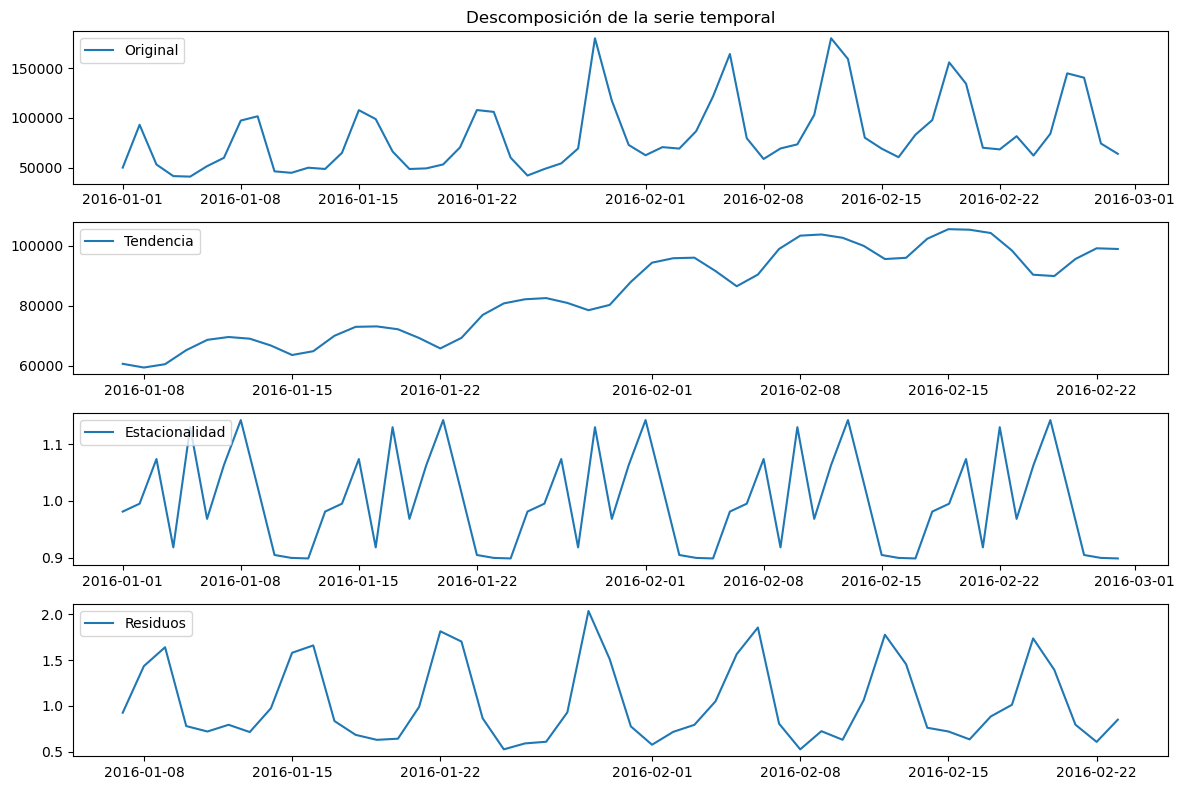

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

ventas.set_index('Fecha', inplace=True)
ventas_ts = ventas['Unidades vendidas'].resample('D').sum() 

# Descomposición de la serie temporal
decomposition = seasonal_decompose(ventas_ts, model='multiplicative', period=12)

# Obtener componentes
tendencia = decomposition.trend
estacionalidad = decomposition.seasonal
residuos = decomposition.resid

# Visualizar componentes
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(ventas_ts, label='Original')
plt.legend(loc='upper left')
plt.title('Descomposición de la serie temporal')

plt.subplot(412)
plt.plot(tendencia, label='Tendencia')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(estacionalidad, label='Estacionalidad')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residuos, label='Residuos')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [15]:
from statsmodels.tsa.stattools import adfuller

# Prueba de Dickey-Fuller aumentada (ADF test)
resultado_adf = adfuller(ventas_ts)

# Imprimir resultados
print('Estadística ADF:', resultado_adf[0])
print('Valor p:', resultado_adf[1])
print('Valores críticos:', resultado_adf[4])

Estadística ADF: -1.1122716705817106
Valor p: 0.7101533761202663
Valores críticos: {'1%': -3.5656240522121956, '5%': -2.920142229157715, '10%': -2.598014675124952}


MAE: 14537.776904691566
RMSE: 17334.055153749734
Porcentaje de error promedio en los datos de prueba: 15.40%
Porcentaje de error promedio (RMSE) en los datos de prueba: 18.36%


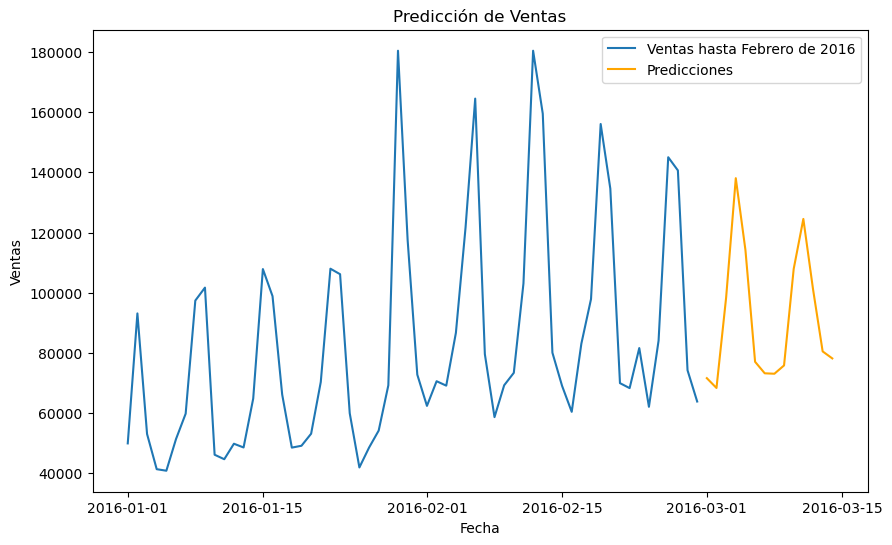

In [16]:
from statsmodels.tsa.arima.model import ARIMA
# Entrenar modelo ARIMA
modelo = ARIMA(ventas_ts, order=(5,1,0))
modelo_entrenado = modelo.fit()

# Realizar predicciones
predicciones = modelo_entrenado.forecast(steps=14)

# Extraer los últimos 20 registros de las ventas reales para compararlas con las predicciones
ventas_reales_ultimos_14 = ventas_ts[-14:]

# Calcular las métricas de error
mae = mean_absolute_error(ventas_reales_ultimos_14, predicciones)
rmse = mean_squared_error(ventas_reales_ultimos_14, predicciones, squared=False)

# Calcular el porcentaje de error promedio
ventas_promedio_test = ventas_reales_ultimos_14.mean()
porcentaje_error_promedio_test = (mae / ventas_promedio_test) * 100

# Calcular el porcentaje de error promedio utilizando RMSE
ventas_promedio_test = ventas_reales_ultimos_14.mean()
porcentaje_error_promedio_rmse = (rmse / ventas_promedio_test) * 100

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'Porcentaje de error promedio en los datos de prueba: {porcentaje_error_promedio_test:.2f}%')
print(f'Porcentaje de error promedio (RMSE) en los datos de prueba: {porcentaje_error_promedio_rmse:.2f}%')

# Visualizar predicciones
plt.figure(figsize=(10, 6))
plt.plot(ventas_ts, label='Ventas hasta Febrero de 2016')
plt.plot(predicciones, color='orange', label='Predicciones')
plt.title('Predicción de Ventas')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()